# Unbounded KSD?

In [1]:
import sys
import os
sys.path.append("/home/lauro/code/msc-thesis/svgd")
import json_tricks as json
import copy

import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd, value_and_grad
from jax import lax
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import numpy as onp
import jax
import pandas as pd
import haiku as hk
from jax.experimental import optimizers

import config

import utils
import metrics
import time
import plot
import stein
import run
import kernels
import svgd

from jax.experimental import optimizers

rkey = random.PRNGKey(0)

/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/jax/lib/xla_bridge.py:125: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [26]:
init = metrics.Gaussian([1,2,3], 1)
target = metrics.Gaussian([0,0,0], 1)

### init kernel:

In [28]:
layer_sizes = [4, 4, 1]
kernel = hk.transform(kernels.make_mlp_ard(layer_sizes))
# def deep_kernel(x, y):
#     mlp = hk.nets.MLP(output_sizes=[1],
#                   w_init=hk.initializers.VarianceScaling(scale=2.0),
# #                   b_init=np.ones,
#                   activation=jax.nn.relu,
#                   activate_final=False)
#     return kernels._ard(mlp(x), mlp(y), logh=0)
# kernel = hk.transform(deep_kernel)

x_dummy, _ = init.sample(2)
kernel_params = kernel.init(rkey, x_dummy, x_dummy)

In [29]:
@jit
def loss(kernel_params, sa, sb):
    kernel_fn = lambda x, y: kernel.apply(kernel_params, x, y)
    return -stein.ksd_squared(sa, sb, target.logpdf, kernel_fn)

### Optimize

In [30]:
opt = svgd.Optimizer(*optimizers.adam(0.03))
opt_state = opt.init(kernel_params)

niter = 100
n = 1000
ksds = []

In [31]:
for step in range(niter):
    kernel_params = opt.get_params(opt_state)
    sa, sb = init.sample(n*2).split(2)
    nksd, g = value_and_grad(loss)(kernel_params, sa, sb)
    ksds.append(-nksd)
    opt_state = opt.update(step, g, opt_state)

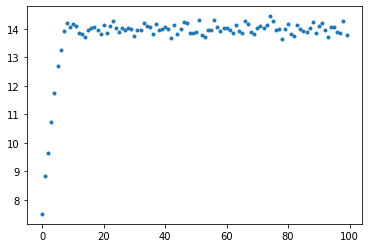

In [32]:
plt.plot(ksds, ".")

# What does the MLP part do?

In [33]:
def feedforward_fn(x):
    mlp = hk.nets.MLP(output_sizes=layer_sizes,
                      w_init=hk.initializers.VarianceScaling(scale=2.0),
                      activation=jax.nn.relu,
                      activate_final=False)
    return mlp(x)
g = hk.transform(feedforward_fn)

In [34]:
x, _ = init.sample(2)
print("x:", x)
print("g(x):", g.apply(kernel_params, x))

x: [-0.16195309  1.3072596   3.2912245 ]
g(x): [0.]


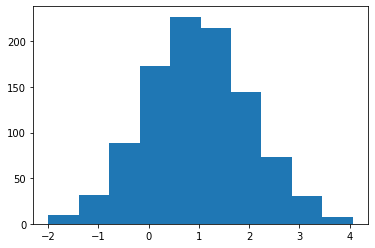

In [35]:
_ = plt.hist(sa[:, 0])

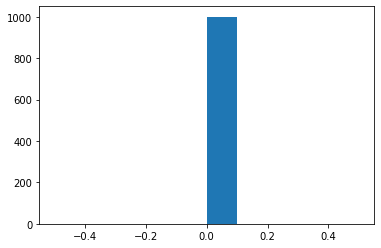

In [36]:
_ = plt.hist(g.apply(kernel_params, sa)[:, 0])

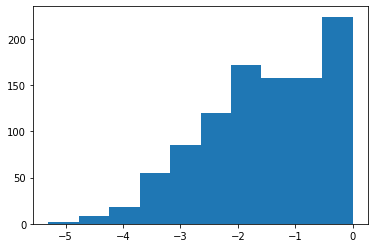

In [37]:
g_params_init = g.init(rkey, x)
_ = plt.hist(g.apply(g_params_init, sa)[:, 0])